# Vision Transformer for Text Classification on CIFAR-10

In [2]:
# Imports
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

### Loading Dataset and Transforming it

In [36]:
def patching(image_tensor, patch_size=8):
  patches = image_tensor.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
  patches = patches.contiguous().view(3, 16, 8, 8)
  return patches

my_transforms = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5]),
                                    ])#transforms.Lambda(lambda x: patching(x, patch_size=8))])

### Total 10 Labels in CIFAR-10 as shown below

In [37]:
# Labels
labels = """airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck""".split()
labels = {i: name for i, name in enumerate(labels)}

In [38]:
# Original Image Size of 32x32 and 10 Classes Present in the dataset
train = datasets.CIFAR10('./', download=True, train=True, transform=my_transforms)
test = datasets.CIFAR10('./', download=True, train=False, transform=my_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [39]:
train_dataloader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

In [40]:
images, label = next(iter(train_dataloader))

In [41]:
images.shape,

(torch.Size([128, 3, 32, 32]),)

In [11]:
[labels[i] for i in label.numpy()]

['horse',
 'dog',
 'bird',
 'truck',
 'ship',
 'cat',
 'airplane',
 'ship',
 'ship',
 'airplane',
 'ship',
 'dog',
 'dog',
 'frog',
 'automobile',
 'bird',
 'bird',
 'horse',
 'deer',
 'horse',
 'horse',
 'dog',
 'horse',
 'dog',
 'airplane',
 'dog',
 'cat',
 'ship',
 'deer',
 'dog',
 'horse',
 'ship',
 'bird',
 'ship',
 'deer',
 'airplane',
 'frog',
 'frog',
 'truck',
 'bird',
 'ship',
 'ship',
 'dog',
 'deer',
 'automobile',
 'truck',
 'truck',
 'dog',
 'horse',
 'truck',
 'dog',
 'bird',
 'horse',
 'truck',
 'bird',
 'dog',
 'deer',
 'dog',
 'truck',
 'deer',
 'airplane',
 'dog',
 'frog',
 'cat',
 'dog',
 'bird',
 'airplane',
 'truck',
 'deer',
 'automobile',
 'truck',
 'dog',
 'ship',
 'horse',
 'cat',
 'truck',
 'frog',
 'cat',
 'horse',
 'truck',
 'horse',
 'airplane',
 'dog',
 'dog',
 'ship',
 'dog',
 'cat',
 'horse',
 'dog',
 'deer',
 'frog',
 'cat',
 'ship',
 'truck',
 'bird',
 'ship',
 'dog',
 'dog',
 'dog',
 'cat',
 'frog',
 'dog',
 'airplane',
 'bird',
 'frog',
 'airplane',

### Plotting Image Patches

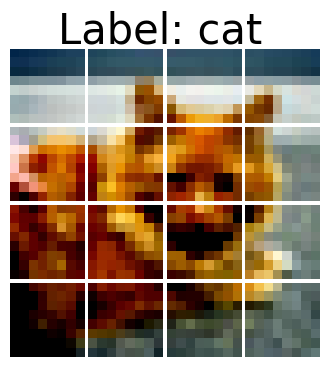

In [12]:
def plot_patches(patches, label, ncols=4):
    n = patches.shape[1]
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols, nrows))
    for i, ax in enumerate(axes.flat):
        if i < n:
            ax.imshow(patches[:,i,:,:].permute(1, 2, 0))  # Convert tensor back to image format
            ax.axis('off')
        else:
            ax.axis('off')
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    fig.suptitle(f"Label: {label}", fontsize=30)
idx = 26
plot_patches(images[idx], labels[label[idx].item()], 4)

## Vision Transformer Model

In [31]:
class EmbedLayer(nn.Module):
    def __init__(self, image_dim):
        super().__init__()
        self.flatten = nn.Flatten(start_dim=2)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, image_dim), requires_grad=True)  # Cls Token
        self.pos_embedding = nn.Parameter(torch.zeros(1, 1, image_dim, requires_grad=True))  # Positional Embedding

    def forward(self, x):
        x = x.permute(0, 2, 3, 4, 1)
        x = self.flatten(x) # Flattening Patches
        x = torch.cat((torch.repeat_interleave(self.cls_token, x.shape[0], 0), x), dim=1)  # Adding classification token at the start of every sequence
        x = x + self.pos_embedding  # Adding positional embedding
        return x

class EmbedLayerWithConv(nn.Module):
    def __init__(self, image_size, embed_dim, n_channels=3, patch_size=8):
        super().__init__()
        self.conv1 = nn.Conv2d(n_channels, embed_dim, kernel_size=patch_size, stride=patch_size)  # Pixel Encoding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim), requires_grad=True)  # Cls Token
        self.pos_embedding = nn.Parameter(torch.zeros(1, (image_size // patch_size) ** 2 + 1, embed_dim), requires_grad=True)  # Positional Embedding

    def forward(self, x):
        x = self.conv1(x)  # B C IH IW -> B E IH/P IW/P (Embedding the patches)
        x = x.reshape([x.shape[0], x.shape[1], -1])  # B E IH/P IW/P -> B E S (Flattening the patches)
        x = x.transpose(1, 2)  # B E S -> B S E
        x = torch.cat((torch.repeat_interleave(self.cls_token, x.shape[0], 0), x), dim=1)  # Adding classification token at the start of every sequence
        x = x + self.pos_embedding  # Adding positional embedding
        return x


In [32]:
class Classifier(nn.Module):
    def __init__(self, embed_dim, mlp_size, n_classes):
        super().__init__()
        # Newer architectures skip fc1 and activations and directly apply fc2.
        self.fc1 = nn.Linear(embed_dim, mlp_size)
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(mlp_size, n_classes)

    def forward(self, x):
        x = x[:, 0, :]  # Get CLS token
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

In [33]:
class VisionTransformer(nn.Module):
    def __init__(self, image_dim, embed_dim, mlp_size, n_layers, n_attention_heads, n_classes):
        super().__init__()
        self.embedding = EmbedLayer(image_dim, embed_dim)
        self.linear = nn.Linear(embed_dim, embed_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_attention_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers, norm=nn.LayerNorm(embed_dim))
        self.classifier = Classifier(embed_dim, mlp_size, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.linear(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x)
        return x

class VisionTransformer(nn.Module):
    def __init__(self, image_dim, embed_dim, mlp_size, n_layers, n_attention_heads, n_classes):
        super().__init__()
        self.embedding = EmbedLayerWithConv(image_dim, embed_dim)
        self.linear = nn.Linear(embed_dim, embed_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_attention_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers, norm=nn.LayerNorm(embed_dim))
        self.classifier = Classifier(embed_dim, mlp_size, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.linear(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x)
        return x

In [46]:
ViT = VisionTransformer(image_dim=32, embed_dim=144, mlp_size=3072,
                        n_layers=4, n_attention_heads=12,
                        n_classes=10)

In [47]:
out = ViT(images)

In [48]:
ViT.embedding(images).shape

torch.Size([128, 17, 144])

In [49]:
ViT.linear(ViT.embedding(images)).shape

torch.Size([128, 17, 144])

In [50]:
out.shape

torch.Size([128, 10])

In [54]:
class ViT_Trainer:
  def __init__(self, train_dataset, test_dataset, device):
    self.device = device
    # self.model = VisionTransformer(image_dim=8*8*3, embed_dim=256, mlp_size=3072,
    #                     n_layers=2, n_attention_heads=8,
    #                     n_classes=10)
    self.model = ViT = VisionTransformer(image_dim=32, embed_dim=288, mlp_size=3072,
                        n_layers=4, n_attention_heads=12,
                        n_classes=10)
    def count_parameters(model):
      return sum(p.numel() for p in model.parameters() if p.requires_grad)

    total_params = count_parameters(self.model)
    print(f"Total parameters in the model: {total_params/1e6}M")
    self.model = self.model.to(self.device)

    self.optimizer = optim.AdamW(self.model.parameters(), lr=5e-4, weight_decay=1e-3)
    self.warm_up_epochs = 10
    self.linear_warmup = optim.lr_scheduler.LinearLR(self.optimizer, start_factor=1/self.warm_up_epochs, end_factor=1.0, total_iters=self.warm_up_epochs, last_epoch=-1, verbose=True)
    self.cos_decay = optim.lr_scheduler.CosineAnnealingLR(optimizer=self.optimizer, T_max=50-self.warm_up_epochs, eta_min=1e-5, verbose=True)

    self.ce = nn.CrossEntropyLoss()
    self.train_dataset = train_dataset
    self.test_dataset = test_dataset

  def train(self, epochs):
    for epoch in range(epochs):
      self.model.train()
      for batch_idx, (images, labels) in enumerate(self.train_dataset):
        images = images.to(self.device)
        labels = labels.to(self.device)

        self.optimizer.zero_grad()
        outputs = self.model(images)
        loss = self.ce(outputs, labels)
        loss.backward()
        self.optimizer.step()

      if epoch < self.warm_up_epochs:
        self.linear_warmup.step()
      else:
        self.cos_decay.step()

      # if batch_idx % 50 == 0:
      #   print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx+1}/{len(self.train_dataset)}, Loss: {loss.item():.4f}")

      accuracy = self.test(self.test_dataset)
      print(f"Epoch {epoch+1}/{epochs}, Accuracy: {accuracy:.4f}")

  def test(self, loader):
        self.model.eval()

        actual = []
        pred = []

        for (x, y) in loader:
            x = x.to(self.device)

            with torch.no_grad():
                logits = self.model(x)
            predicted = torch.max(logits, 1)[1]

            actual += y.tolist()
            pred += predicted.tolist()

        acc = accuracy_score(y_true=actual, y_pred=pred)
        return acc

In [55]:
trainer = ViT_Trainer(train_dataloader, test_dataloader, device)

Total parameters in the model: 8.643434M


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [56]:
trainer.train(50)

Epoch 1/50, Accuracy: 0.4116
Epoch 2/50, Accuracy: 0.4881
Epoch 3/50, Accuracy: 0.5313
Epoch 4/50, Accuracy: 0.5691
Epoch 5/50, Accuracy: 0.5765
Epoch 6/50, Accuracy: 0.6008
Epoch 7/50, Accuracy: 0.6162
Epoch 8/50, Accuracy: 0.6234
Epoch 9/50, Accuracy: 0.6291
Epoch 10/50, Accuracy: 0.6255
Epoch 11/50, Accuracy: 0.6320
Epoch 12/50, Accuracy: 0.6519
Epoch 13/50, Accuracy: 0.6461
Epoch 14/50, Accuracy: 0.6524
Epoch 15/50, Accuracy: 0.6583
Epoch 16/50, Accuracy: 0.6597
Epoch 17/50, Accuracy: 0.6588
Epoch 18/50, Accuracy: 0.6617
Epoch 19/50, Accuracy: 0.6634
Epoch 20/50, Accuracy: 0.6630
Epoch 21/50, Accuracy: 0.6701
Epoch 22/50, Accuracy: 0.6791
Epoch 23/50, Accuracy: 0.6763
Epoch 24/50, Accuracy: 0.6838
Epoch 25/50, Accuracy: 0.6735
Epoch 26/50, Accuracy: 0.6789
Epoch 27/50, Accuracy: 0.6888
Epoch 28/50, Accuracy: 0.6877
Epoch 29/50, Accuracy: 0.6870
Epoch 30/50, Accuracy: 0.6884
Epoch 31/50, Accuracy: 0.6885
Epoch 32/50, Accuracy: 0.6927
Epoch 33/50, Accuracy: 0.6923
Epoch 34/50, Accura

In [57]:
trainer.train(10)

Epoch 1/10, Accuracy: 0.7149
Epoch 2/10, Accuracy: 0.7156
Epoch 3/10, Accuracy: 0.7173
Epoch 4/10, Accuracy: 0.7139
Epoch 5/10, Accuracy: 0.7161
Epoch 6/10, Accuracy: 0.7149
Epoch 7/10, Accuracy: 0.7158
Epoch 8/10, Accuracy: 0.7175
Epoch 9/10, Accuracy: 0.7166
Epoch 10/10, Accuracy: 0.7164
